<a href="https://colab.research.google.com/github/austinbennysmith/CMIP6/blob/main/N_S_Temps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fsspec
!pip install netCDF4
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
!pip install eofs
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
from eofs.xarray import Eof
from nc_time_axis import NetCDFTimeConverter, CalendarDateTime
import cftime
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/EEPS_1430/EEPS 1430 Final Project/images'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

In [98]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
ssp585 = df.query("variable_id == 'tas' & experiment_id == 'ssp585' & table_id == 'Amon' & source_id == 'CanESM5'")
experiment_id = 'ssp585'
source_id = 'CESM2'
memnum = '3'
ssp585

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
296058,ScenarioMIP,CCCma,CanESM5,ssp585,r10i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429
296204,ScenarioMIP,CCCma,CanESM5,ssp585,r10i1p2f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429
296349,ScenarioMIP,CCCma,CanESM5,ssp585,r11i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429
296443,ScenarioMIP,CCCma,CanESM5,ssp585,r11i1p2f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429
296538,ScenarioMIP,CCCma,CanESM5,ssp585,r12i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429
296632,ScenarioMIP,CCCma,CanESM5,ssp585,r12i1p2f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429
296727,ScenarioMIP,CCCma,CanESM5,ssp585,r13i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429
296821,ScenarioMIP,CCCma,CanESM5,ssp585,r13i1p2f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429
296916,ScenarioMIP,CCCma,CanESM5,ssp585,r14i1p1f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429
297010,ScenarioMIP,CCCma,CanESM5,ssp585,r14i1p2f1,Amon,tas,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp585/r1...,NaN,20190429


In [ ]:
ssp = df.query("variable_id == 'tas' & experiment_id == 'ssp585' & table_id == 'Amon'")
unique_sources = []
for i in ssp['source_id']:
  if i not in unique_sources:
    unique_sources.append(i)
print(unique_sources)

for i in unique_sources:
  x = ssp.query("source_id =="+"'"+i+"'")
  print(str(len(x))+': '+i)

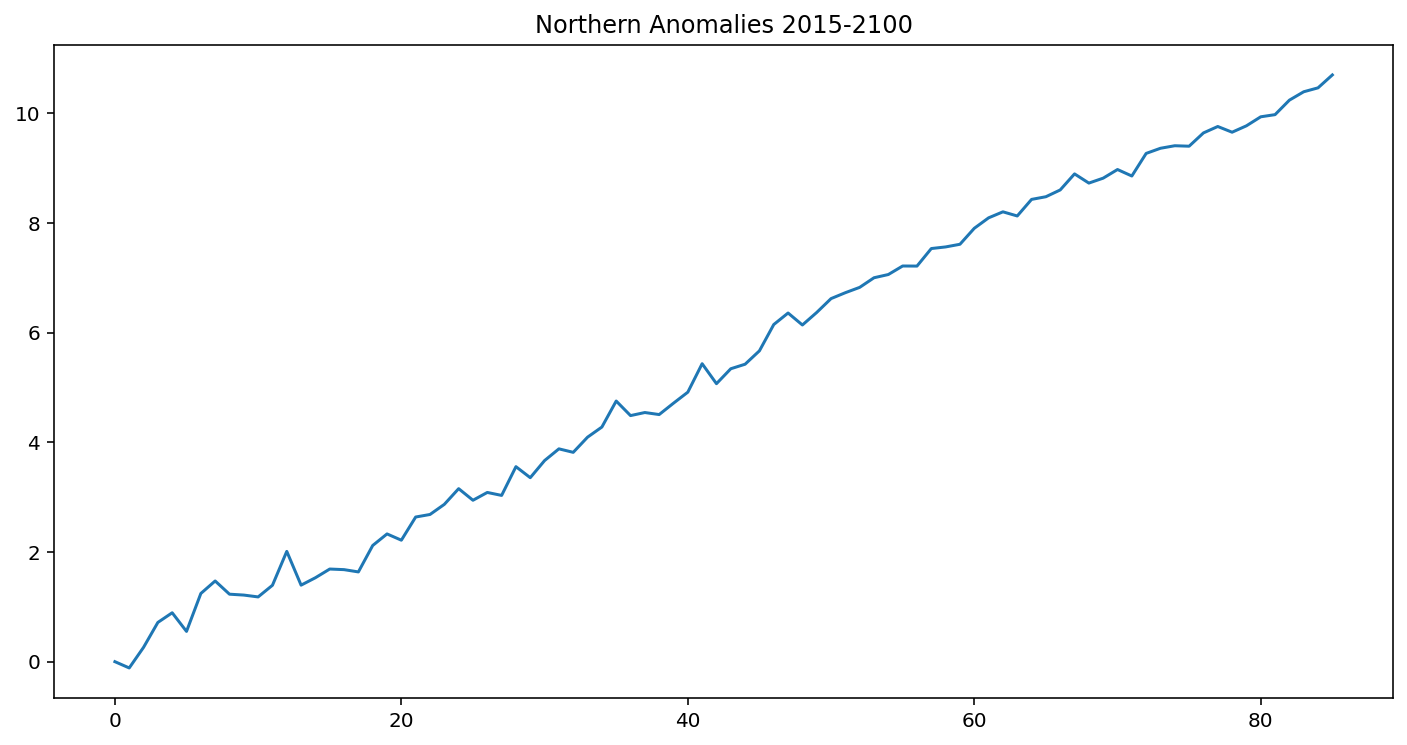

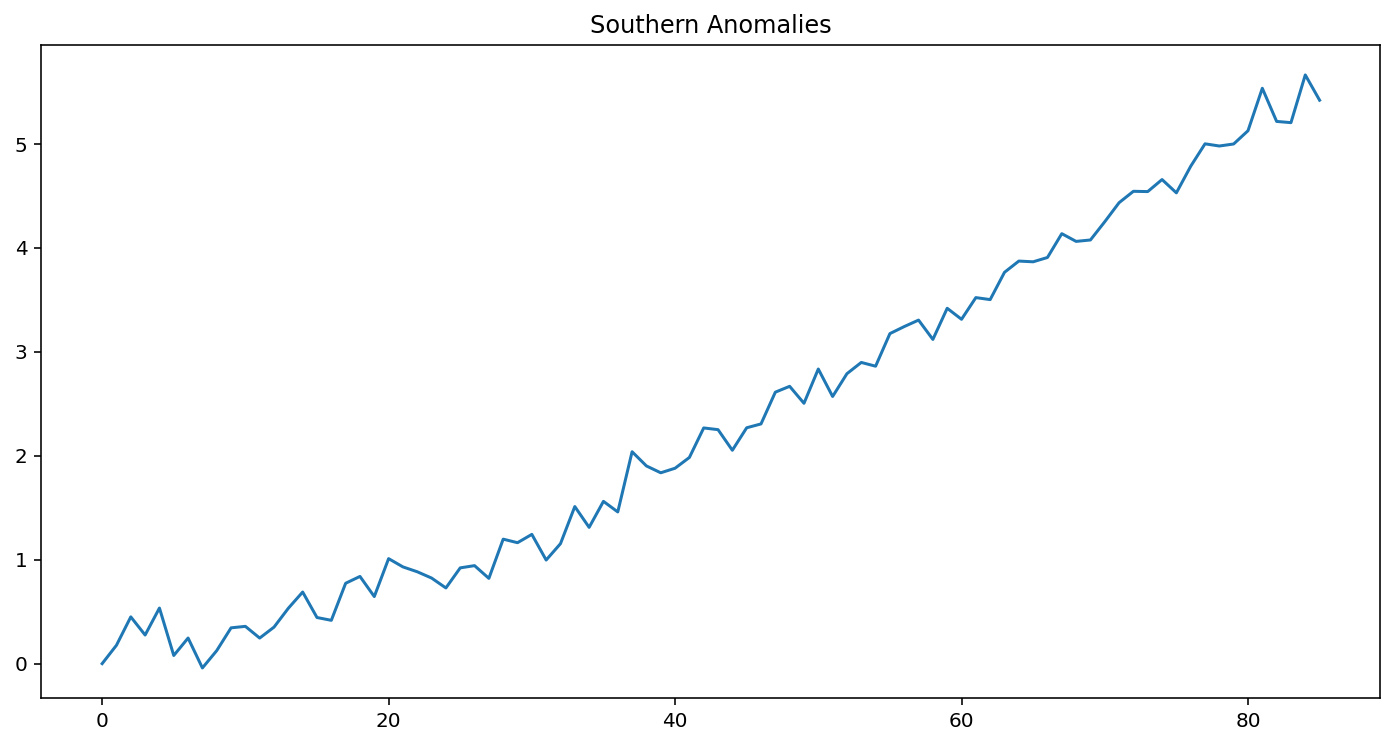

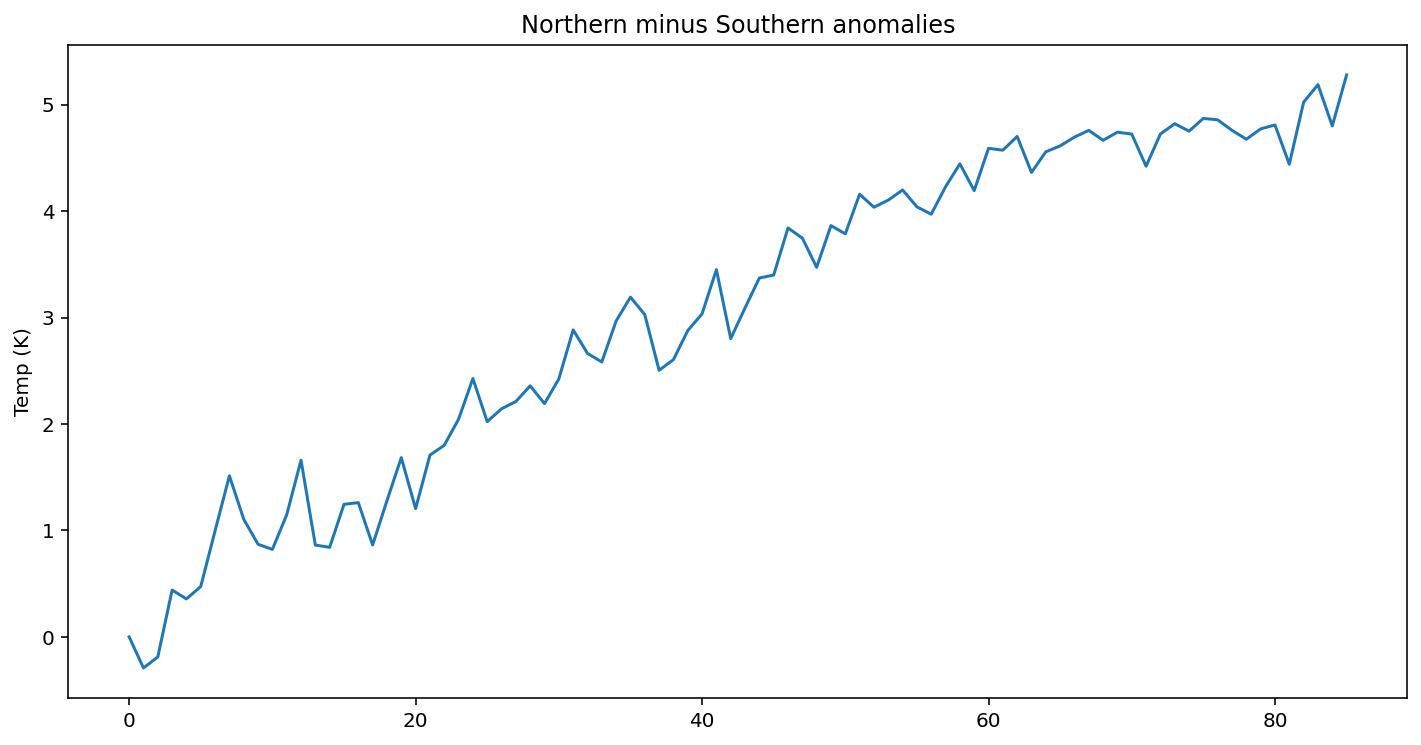

In [106]:
zstore = ssp585.zstore.values[0]
mapper = fsspec.get_mapper(zstore)
ds = xr.open_zarr(mapper, consolidated=True, decode_times=True)

nlon = len(ds.tas.lon)
tasN = ds.tas.sel(lat=slice(24,90))
nlat = len(tasN.lat)
tasN2d = np.reshape(tasN.values, (1032, nlat*nlon))
tasNspacemean = np.mean(tasN2d, axis=1) # Averaging along lat & lon
tasN12months = np.reshape(tasNspacemean, (86, 12))
tasNmean = np.mean(tasN12months, axis=1) # Average for each year
tasNmeanAnomaly = tasNmean - tasNmean[0] # Anomaly
plt.plot(tasNmeanAnomaly)
plt.title('Northern Anomalies 2015-2100')
plt.show()

tasS = ds.tas.sel(lat=slice(-90, -24))
tasS2d = np.reshape(tasS.values, (1032, nlat*nlon))
tasSspacemean = np.mean(tasS2d, axis=1)
tasS12months = np.reshape(tasSspacemean, (86, 12))
tasSmean = np.mean(tasS12months, axis=1)
tasSmeanAnomaly = tasSmean - tasSmean[0]
plt.plot(tasSmeanAnomaly)
plt.title('Southern Anomalies')
plt.show()

tasMeanAnomalyDiff = tasNmeanAnomaly - tasSmeanAnomaly # Difference in N and S hemisphere anomalies
plt.plot(tasMeanAnomalyDiff)
plt.title('Northern minus Southern anomalies')
plt.ylabel('Temp (K)')
plt.show()

In [ ]:
# zstore = ssp585.zstore.values[0]
# mapper = fsspec.get_mapper(zstore)
# ds = xr.open_zarr(mapper, consolidated=True, decode_times=True)

# nlon = len(ds.tas.lon)
# tasN = ds.tas.sel(lat=slice(24,90))
# nlat = len(tasN.lat)
# tasN2d = np.reshape(tasN.values, (1980, nlat*nlon))
# tasNspacemean = np.mean(tasN2d, axis=1)
# tasN12months = np.reshape(tasNspacemean, (165, 12))
# tasNmean = np.mean(tasN12months, axis=1)
# tasNmeanAnomaly = tasNmean - tasNmean[0]
# plt.plot(tasNmeanAnomaly)
# plt.show()

# tasS = ds.tas.sel(lat=slice(-90, -24))
# tasS2d = np.reshape(tasS.values, (1980, nlat*nlon))
# tasSspacemean = np.mean(tasS2d, axis=1)
# tasS12months = np.reshape(tasSspacemean, (165, 12))
# tasSmean = np.mean(tasS12months, axis=1)
# tasSmeanAnomaly = tasSmean - tasSmean[0]
# plt.plot(tasSmeanAnomaly)
# plt.show()

# tasMeanAnomalyDiff = tasNmeanAnomaly - tasSmeanAnomaly
# plt.plot(tasMeanAnomalyDiff)